In [1]:
print('\033[32mDL\033[0m')

DL


In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

D:\anaconda\python.exe
3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pytz
import datetime
try:
    import talib
    import ccxt
except ImportError:
    ! conda install -c conda-forge ta-lib
    ! pip install ccxt
    import talib
    import ccxt
import time

pd.set_option('display.max_rows', 5000)
pd.set_option('expand_frame_repr', False)

In [4]:
currency_lst = ['ETH/USDT', 'DOGE/USDT', 'BUSD/USDT', 'SOL/USDT', 'FIL/USDT', 'LTC/USDT', 'BNB/USDT', 'APT/USDT', 'XRP/USDT']

In [5]:
# create the exchange object
exchange = ccxt.binance()
# set the timeframe to 1 minute
timeframe = '1m'
# set the start time to 1 month before
start_time = int(datetime.datetime.strptime("2022-12-01 00:00:00", "%Y-%m-%d %H:%M:%S").timestamp() * 1000)
# set the end time to the current time
end_time = int(datetime.datetime.strptime("2022-12-31 23:59:59", "%Y-%m-%d %H:%M:%S").timestamp() * 1000)
# set the number of data points to fetch per API request
limit = 1000

In [6]:
# create an empty dataframe to hold the results
df_btc = pd.DataFrame()

In [7]:
# loop through the time range and fetch data
while start_time < end_time:
    # fetch the OHLCV data
    ohlcv_btc = exchange.fetch_ohlcv('BTC/USDT', timeframe, since=start_time, limit=limit)
    # convert the data to a pandas dataframe
    df = pd.DataFrame(ohlcv_btc, columns=['timestamp', 'open', 'high', 'low', 'BTC_close', 'BTC_volume'])
    # append the data to the main dataframe
    df_btc = pd.concat([df_btc, df])
    # set the start time for the next request
    start_time = int(df['timestamp'].iloc[-1]) + 60 * 1000

In [8]:
# convert the timestamp to datetime format and set timezone Toronto time
df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/Toronto').dt.strftime('%Y-%m-%d %H:%M:%S')

In [9]:
# set the timestamp as the index
df_btc.set_index('timestamp', inplace=True)

In [10]:
# get close price and volume for BTC
df_btc_px = df_btc['BTC_close']
df_btc_vol = df_btc['BTC_volume']
df = pd.merge(df_btc_px, df_btc_vol, on='timestamp')

#### Get data for rest 9 cryptos, please wait for API to fetch data, it may takes 2 minutes to get 10 cryptos data. This is because when request data from binance, it only gives 1000 data once (OKX is 100). Should use while loop to get full data.

In [12]:
for crypto in currency_lst:
    cur = crypto[:-5]
    close = cur + '_close'
    volume = cur + '_volume'
    start_time = int(datetime.datetime.strptime("2022-12-01 00:00:00", "%Y-%m-%d %H:%M:%S").timestamp() * 1000)
    df_crypto = pd.DataFrame()
    while start_time < end_time:
        # fetch the OHLCV data
        ohlcv_temp = exchange.fetch_ohlcv(crypto, timeframe, since=start_time, limit=limit)
        # convert the data to a pandas dataframe
        df_temp = pd.DataFrame(ohlcv_temp, columns=['timestamp', 'open', 'high', 'low', close, volume])
        # append the data to the main dataframe
        df_crypto = pd.concat([df_crypto, df_temp])
        # set the start time for the next request
        start_time = int(df_temp['timestamp'].iloc[-1]) + 60 * 1000
    df_crypto['timestamp'] = pd.to_datetime(df_crypto['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/Toronto').dt.strftime('%Y-%m-%d %H:%M:%S')
    # set the timestamp as the index
    df_crypto.set_index('timestamp', inplace=True)
    df_crypto_px = df_crypto[close]
    df_crypto_vol = df_crypto[volume]
    df_merge = pd.merge(df_crypto_px, df_crypto_vol, on='timestamp')
    df = pd.merge(df, df_merge, on='timestamp')

In [18]:
# Use exactly 1 moth data
df = df.loc['2022-12-01':'2023-01-01']

In [19]:
df.to_csv("binance_1m_data.csv", index=True)

### If you have the data "binance_1m_data.csv" locally, start from here

In [62]:
df = pd.read_csv('binance_1m_data.csv', index_col='timestamp', parse_dates=True)

In [77]:
# set three levels of index to this dataframe
df_group = df.reset_index()
day_list = list(df_group['timestamp'].dt.day)
timestamp_list = list(df_group['timestamp'])
half_hour_index_list = [i // 30 for i in range(len(df_group))]
df['half_hour_index'] = half_hour_index_list
arrays = [day_list, half_hour_index_list, timestamp_list]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["day", "halfhour", "timestamp"])
df = df.set_index(index)

In [78]:
df.head()

BTC_close  BTC_volume  ETH_close  ETH_volume  DOGE_close  DOGE_volume  BUSD_close  BUSD_volume  SOL_close  SOL_volume  ...  FIL_volume  LTC_close  LTC_volume  BNB_close  BNB_volume  APT_close  APT_volume  XRP_close  XRP_volume  half_hour_index
day halfhour timestamp                                                                                                                                   ...                                                                                                                         
1   0        2022-12-01 00:00:00   17139.92    60.46078    1284.21    491.3964     0.10405    2921200.0      0.9999     158196.0      13.93      415.45  ...     6159.63      76.89     132.571      295.8     271.762     4.7110     4685.39     0.4016     94425.0                0
             2022-12-01 00:01:00   17145.69   162.89521    1284.69    302.3785     0.10409    1351640.0      0.9999     108654.0      13.96     4871.80  ...      804.73      76.94     160.005      295.8     331.940     4.7147     1618.52     0.4019     62265.0                0
             2022-12-01 00:02:00   17139.58   109.27355    1284.74    185.1130     0.10407    1328122.0      0.9999     265629.0      13.96       84.12  ...      165.35      76.93     111.689      296.3     481.237     4.7129     2737.81     0.4019     33644.0                0
             2022-12-01 00:03:00   17130.85   173.34153    1283.76    236.7988     0.10396    1527258.0      0.9999    1024083.0      13.93     1419.25  ...      267.77      76.89     127.432      296.2     231.712     4.7096      546.72     0.4014     73504.0                0
             2022-12-01 00:04:00   17132.51    83.08581    1284.09    179.8127     0.10399     789597.0      0.9999     408409.0      13.93     1028.07  ...     1210.68      76.92      87.605      296.1     210.636     4.7112     1860.88     0.4015    118468.0                0

[5 rows x 21 columns]

#### There 48 half-hour per day, split them into 48 dataframe and label them as df_48_x, x means xth half-hour for the day.

    df_48_01: from 00:00 to 00:29
    df_48_02: from 00:30 to 00:59
                 ...
    df_48_47: from 23:00 to 23:29
    df_48_48: from 23:30 to 00:59

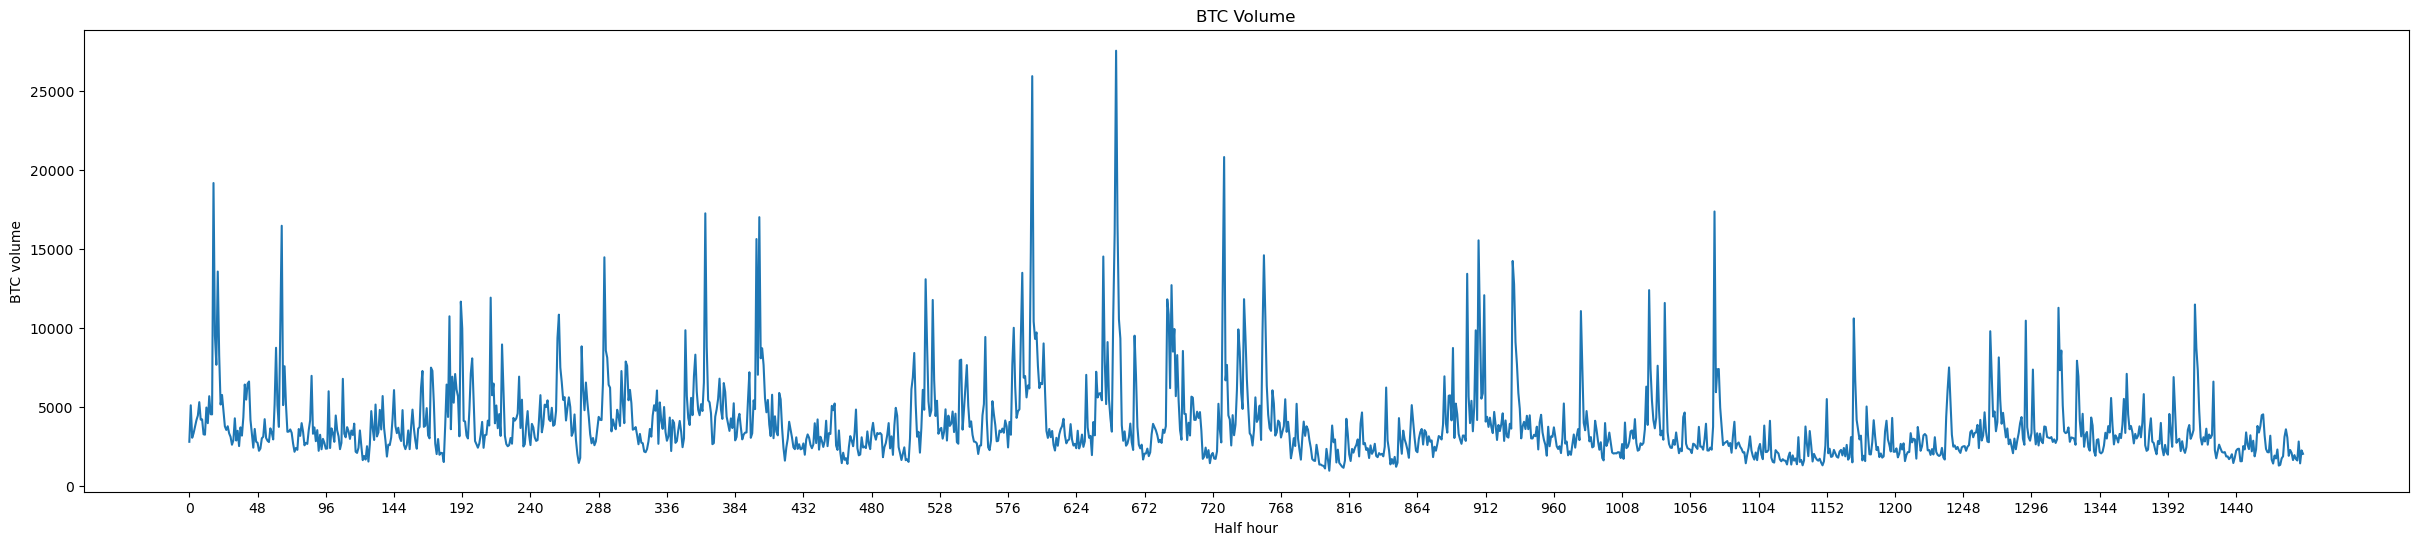

In [104]:
# Group the data by day and sum the 'BTC_volume' column
daily_BTC_volume = df.groupby(level='halfhour')['BTC_volume'].sum()

# Plot the daily BTC volume
fig, ax = plt.subplots(figsize=(30,6))
daily_BTC_volume.plot(ax=ax, kind='line')
ax.set_title('BTC Volume')
ax.set_xlabel('Half hour')
ax.set_ylabel('BTC volume')

# Set the tick positions and labels for the x-axis
ticks = np.arange(0, len(daily_BTC_volume), 48)
ax.set_xticks(ticks)

# Save the figure as a PDF file
fig.savefig('btc_volume.pdf', bbox_inches='tight')